# Pre-processing of venue pdf and route calculation

## Introduction

It is not uncommon that visitors aim to buy as much as they can in events, and it is always necessary for them to keep track of the purchase progress. Big events like Comiket allows visitors to save their targeted booths with functions of web catalog, enabling them to make a comprehensive preparation before events, as well as a better control during events.<br><br>
However, smaller events like only-event do not have such resources to provide web support, and visitors need to use original and inconvenient methods like printing the venue map for them to refer to throughout the event.<br><br>
In view of this, given that the Internet condition is good enough, this project allows visitors to achieve these objectives using their individual devices as a replacement of the official web catalog services. It also provides a route calculation function, helping users to figure out the shortest path to traverse all the interested booths.<br><br>
This project uses にじそうさく09 as an example.

## Description of event used (にじそうさく09)

This event was held at one big hall (combining three halls) at Tokyo Big Sight in 2024.

## Initializations

### Libraries needed

In [1]:
!pip install PyMuPDF

In [2]:
import fitz  # PyMuPDF
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import pandas as pd
import re
%matplotlib inline

### Declaration of global variables

In [3]:
KATAKANA_LIST = "アイウエオカキクケコサシスセソタチツテトナニヌネノハパヒピフプヘペホポマミムメモヤユヨラリルレロワヲン"
HIRAGANA_LIST = "あいうえおかきくけこさしすせそたちつてとなにぬねのはぱひぴふぷへぺほぽまみむめもやゆよらりるれろわをん"
UPPERCASE_LIST = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
LOWERCASE_LIST = "abcdefghijklmnopqrstuvwxyz"

x1, y1, x2, y2 = 750, 1168, 4045, 2418     # boundaries to be cropped on pdf
MAX_BOOTH_NUM = 86
CHAR_LIST_ROW1 = "クケコサシスセソタチツテトナニヌネノハヒフへほまみむめもやゆよ"
CHAR_LIST_ROW2 = "BCDEFGHIJKLMNOPQRSTUVWXYZアイウエオカキ"


This project use the lower 4 variables to undergo the pre-processing stage. These 4 variables are case-specific, so they need to be changed when another event is to be processed.

### Variables initialization

In [4]:
limits = {}   ## Boundaries (x1, y1, x2, y2) of each row
x_bins1 = []   ## Bins of x1 for first row (big label)
x_bins2 = []   ## Bins of x1 for first row (big label)
locations = {}

y_max1 = 0  ## find the lowest y4 coords
y_max2 = 0  ## find the lowest y4 coords

## Preprocessing of pdf page

Pre-processing of pdf page involves default pdf text recognition, searching locations of numbers on pdf page.<br><br>
There are several things to be taken care of when doing the location search:<br><br>
- Sizes of text bounding boxes<br>
This has to be aware of in order not to mix up row text and text of booth names (e.g. メ of メロンブックス and row メ)<br><br>
- Text alignment of birthday seats<br>
In this example, each booth number digit of birthday seats is separated, so extra procedures are needed (finding each digit one by one and group the digits together)<br><br>
- Occurrence of row labels<br>
Row labels of non-kabe-rows occur twice, while those of kabe-rows occur once<br><br>

Procedures of pre-processing:<br>
1. Find row 1 from row names: y-bottom (y_max1), x_bins1
2. Find row 2 from row names: y-bottom (y_max2), x_bins2
3. Find kabe-circle x-boundary and save to x_-_bins1 and x_bins2
4. Find locations of non-birthday booth numbers and match the location to row.
5. Find locations of birthday booth numbers and match the location to row.
6. Export the matchings to json.

### Load pdf

In [5]:
# Open the provided PDF file
file_path = "/home/cornerpc/Downloads/243409_456_H_20240422_128568d3cc.pdf"
pdf_document = fitz.open(file_path)
page = pdf_document.load_page(0)

As this event is held at one single hall, the loaded map only involves 1 page.

### Find locations of booths

In [6]:
# Find all boundaries of 1st row
for search_text in CHAR_LIST_ROW1:

    text_instances = page.search_for(search_text)
    
    # Find row name inside the rectangle concerned
    # Size of row name should be large enough in order not to mix up with words with the Japanese character (>25)

    # Skip row names without any search results
    if len(text_instances) > 0:

        # char_list += search_text  ## Add the row char found to char_list

        # Find initial boundaries [(x1, y1, x2, y2), (x3, y3, x4, y4)]
        v = [coords for coords in sorted(text_instances, key=lambda x: x[0]) if coords[0] >= x1 and coords[1] >= y1 \
                                    and coords[2] <= x2 and coords[3] <= y2\
                                        and coords[3] - coords[1] > 25]
        
        # Set boundaries with center of x1, x2 +-30.
        limits[search_text] = [(v[0][0]+v[0][2])/2-30, v[0][1], (v[0][0]+v[0][2])/2+30, v[1][3]]

        # Update lowest y4 coords
        if y_max1 < v[1][3]:
            y_max1 = v[1][3]
        x_bins1.append((v[0][0]+v[0][2])/2-30)


# Find x-boundaries of 2nd row
for search_text in CHAR_LIST_ROW2:

    text_instances = page.search_for(search_text)
    
    # Find row name inside the rectangle concerned
    # Size of row name should be large enough in order not to mix up with words with the Japanese character (>25)

    # Skip row names without any search results
    if len(text_instances) > 0:

        # char_list += search_text  ## Add the row char found to char_list

        # Find initial boundaries [(x1, y1, x2, y2), (x3, y3, x4, y4)]
        v = [coords for coords in sorted(text_instances, key=lambda x: x[1]) if coords[0] >= x1 and coords[1] >= y1 \
                                    and coords[2] <= x2 and coords[3] <= y2\
                                        and coords[3] - coords[1] > 25]
        
        # Set boundaries with center of x1, x2 +-30.
        limits[search_text] = [(v[1][0]+v[1][2])/2-30, v[0][1], (v[1][0]+v[1][2])/2+30, v[1][3]]

        # Update lowest y4 coords
        if y_max2 < v[1][3]:
            y_max2 = v[1][3]
        x_bins2.append((v[0][0]+v[0][2])/2-30)

# Find boundaries for kabe-circles: Row label only occurs once

for search_text in ["ら"]:

    text_instances = page.search_for(search_text)
    
    # Find row name inside the rectangle concerned
    # Size of row name should be large enough in order not to mix up with words with the Japanese character (>25)

    # Skip row names without any search results
    if len(text_instances) > 0:

        # Find initial boundaries [(x1, y1, x2, y2), (x3, y3, x4, y4)]
        v = [coords for coords in sorted(text_instances, key=lambda x: x[1]) if coords[0] >= x1 and coords[1] >= y1 \
                                    and coords[2] <= x2 and coords[3] <= y2\
                                        and coords[3] - coords[1] > 30]

        x_bins1.append((v[0][0]+v[0][2])/2-30)
        x_bins2.append((v[0][0]+v[0][2])/2-30)

CHAR_LIST_ROW1 += "ら"
CHAR_LIST_ROW2 += "A"

booth_locations = []

# Correspond each location of booth num to rows
for i in range(MAX_BOOTH_NUM + 1):
    search_text = f"{i:02d}"
    text_instances = page.search_for(search_text)

    # Find the center of each text
    booth_num_x = [(coords[0]+coords[2])/2 for coords in text_instances if coords[0] >= x1 and coords[1] >= y1 \
                        and coords[2] <= x2 and coords[3] <= y2\
                        and coords[3] - coords[1] < 20]
    
    booth_num_y = [(coords[1]+coords[3])/2 for coords in text_instances if coords[0] >= x1 and coords[1] >= y1 \
                        and coords[2] <= x2 and coords[3] <= y2\
                        and coords[3] - coords[1] < 20]
    

    # Append locations of bounding box of each booth text
    booth_locations.append([coords for coords in text_instances if coords[0] >= x1 and coords[1] >= y1 \
                        and coords[2] <= x2 and coords[3] <= y2\
                        and coords[3] - coords[1] < 20])
    
    booth_locations = [x for x in booth_locations if x != []]
    
    # Distinguish if the booth is in 1st or second row
    corr_row = np.digitize(booth_num_y, [y_max1, y_max2], right = False)

    for j in range(len(corr_row)):
        if corr_row[j] == 0:
            row = CHAR_LIST_ROW1[np.digitize(booth_num_x[j], x_bins1, right = False) - 1]

        elif corr_row[j] == 1:
            row = CHAR_LIST_ROW2[np.digitize(booth_num_x[j], x_bins2, right = False) - 1]

        if row not in locations:
            locations[row] = {}
        locations[row][f"{i:02d}"] = (booth_num_x[j], booth_num_y[j])

# Find birthday seats, using the features that the found text has a super flat bounding box

birthday_center = {}

for i in range(10):

    text_instances = page.search_for(str(i))

    # Find the center of each text
    booth_loc = [((coords[0]+coords[2])/2, (coords[1]+coords[3])/2) for coords in text_instances if coords[0] >= x1 and coords[1] >= y1 \
                        and coords[2] <= x2 and coords[3] <= y2\
                        and coords[3] - coords[1] < 5]
    
    birthday_center[i] = booth_loc

match_dict = {}
for i in range(10):

    for center in birthday_center[i]:

        for j in range(10):
            
            for which_center in birthday_center[j]:

                if center[0] - 3 < which_center[0] and which_center[0] < center[0] + 3 \
                    and center[1] +7 < which_center[1] and which_center[1] < center[1] + 13:

                    if f"{i}{j}" not in match_dict:
                        match_dict[f"{i}{j}"] = []

                    match_dict[f"{i}{j}"].append([(center[0]+which_center[0])/2, (center[1]+which_center[1])/2])

## Correspond each location of booth num to rows (2nd part)
match_dict_to_export = {}   # Save all kabe and birthday booths (booths where faces the horizontal walking paths)
for key in match_dict:

    for coords in match_dict[key]:
        # Distinguish if the booth is in 1st or second row
        corr_row = np.digitize(coords[1], [y_max1, y_max2], right = False)

        if corr_row == 0:
            row = CHAR_LIST_ROW1[np.digitize(coords[0], x_bins1, right = False) - 1]

        elif corr_row == 1:
            row = CHAR_LIST_ROW2[np.digitize(coords[0], x_bins2, right = False) - 1]

        elif corr_row == 2:
            row = "A"

        locations[row][key] = (coords[0], coords[1])

        if row not in match_dict_to_export:
            match_dict_to_export[row] = []

        match_dict_to_export[row].append(key)  # Save booths where the booth num is split (not necessarily birthday seats)

for row in ["ら", "A"]:     # These two rows are all kabe-circles
    match_dict_to_export[row] = list(locations[row].keys())


In [7]:
## Export birthday_kabe_booths to json
with open("birthday_kabe_booths.json", "w") as outfile: 
    json.dump(match_dict_to_export, outfile)

In [8]:
## Export locations to json
with open("locations.json", "w") as outfile: 
    json.dump(locations, outfile)

## Visualize map and walking routes

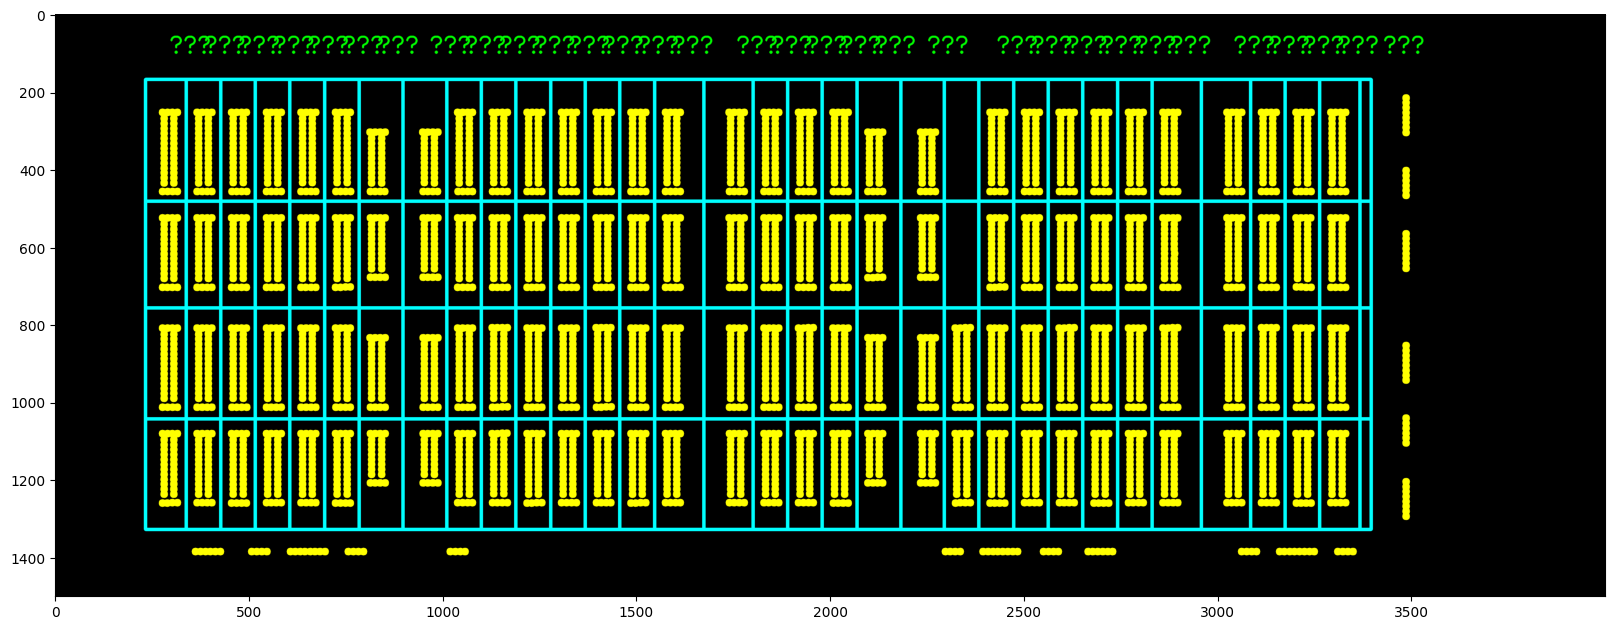

In [9]:
img = np.zeros((3000,5000,3), dtype=np.uint8)

# Plot all circle locations
for row in locations:
    for coords in locations[row].values():

        img = cv2.circle(img, tuple([int(x) for x in coords]), 10, (255, 255, 0), -1)

# Plot all row labels
row_center_list = [int(x)+30 for x in x_bins1]
for i in range(len(row_center_list)):

    img = cv2.putText(img, CHAR_LIST_ROW1[i], (row_center_list[i], 1100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)

## Plot all walking paths
# find x and y coordinates of walking paths
test_x_row = [int(min(x_bins2) - 30)]
row_center_list = [int(x)+30 for x in x_bins2]   ## the +30 here is to convert the bin back to center of row, defined when x_bins2 was generated

for i in range(len(row_center_list) - 1):
    test_x_row.append(int((row_center_list[i] + row_center_list[i+1])/2))

test_x_row.append(int(max(x_bins2)))
test_y_row = [y1, int((y1 + int(y_max1))/2)+20, int(y_max1), int((y_max1 + y_max2)/2), int(y_max2)]

# Plot the walking paths
for x in test_x_row:
    img = cv2.line(img, (x, test_y_row[0]), (x, test_y_row[-1]), (0, 255, 255), 7)

for y in test_y_row:
    img = cv2.line(img, (test_x_row[0], y), (test_x_row[-1], y), (0, 255, 255), 7)


img = img[1000:2500, 500:4500]

plt.figure(figsize=(20, 12))
plt.imshow(img,cmap='gray', clip_on=False)
plt.show()

## Route calcuation

The following functions simplifies the graph to calculate the shortest distance between two booths

In [10]:
## The following procedure reduces the node dict to at most 6 nodes for path calculation
def concerned_coords(test_x_row, test_y_row, start, end):

    # concerned nodes along x- / y-axis
    x_can = set()
    y_can = set()

    # Assume that start/end must lie at walking route but not at any nodes themselves!
    # If start/end lie along x-axis of any nodes, store x-coords of adjacent nodes, store its y coords
    # and vice versa 
    if start[0] not in test_x_row:
        bin_id = np.digitize(start[0], test_x_row)
        x_can.add(test_x_row[bin_id-1])
        x_can.add(test_x_row[bin_id])

        y_can.add(start[1])

    if end[0] not in test_x_row:

        bin_id = np.digitize(end[0], test_x_row)

        x_can.add(test_x_row[bin_id-1])
        x_can.add(test_x_row[bin_id])

        y_can.add(end[1])

    if start[1] not in test_y_row:
        bin_id = np.digitize(start[1], test_y_row)
        y_can.add(test_y_row[bin_id-1])

        if bin_id != len(test_y_row):
            y_can.add(test_y_row[bin_id])

        x_can.add(start[0])

    if end[1] not in test_y_row:
        bin_id = np.digitize(end[1], test_y_row)
        y_can.add(test_y_row[bin_id-1])
        if bin_id != len(test_y_row):
            y_can.add(test_y_row[bin_id])

        x_can.add(end[0])


    test_x_row = sorted(list(x_can))
    test_y_row = sorted(list(y_can))

    return test_x_row, test_y_row

In [11]:
def enter(route_dict, current, end, route, dist, layer):

    #update route
    route.append(current)
    layer += 1

    # # Limit recursion depth: it can't exceed 4 using the simplified map:
    # if layer == 5:
    #     return [], 100000000

    min_dist = -1
    min_route = []

    for new_coords in route_dict[current]:

        if new_coords in route:
            continue

        # If new position is the destination, avoid recursion

        if end == new_coords:
            
            temp_dist = dist + abs(sum(np.subtract(current, new_coords)))
            temp_route = route[:]
            temp_route.append(new_coords)
            if min_dist < 0 or temp_dist < min_dist:
                min_dist = temp_dist
                min_route = temp_route

            return min_route, min_dist

        # If new position is not the destination, do recursion

        elif layer < 4:
            temp_route, temp_dist = enter(route_dict, new_coords, end, route[:], dist + abs(sum(np.subtract(current, new_coords))), layer)

            if (min_dist < 0 or temp_dist < min_dist) and temp_dist >= 0:

                min_dist = temp_dist
                min_route = temp_route

        
        if min_dist == -1:
            min_dist = 100000000

    return min_route, min_dist

In [12]:
def gen_route_dict(test_x_row, test_y_row):

    route_dict = {}
    id_list = []

    # Generate route dict
    for i in range(len(test_x_row)):
        for j in range(len(test_y_row)):
            id_list.append((i, j))

    for id_pair in id_list:

        i, j = id_pair[0], id_pair[1]
        current_coord = (test_x_row[i], test_y_row[j])
        
        if current_coord not in route_dict:
            route_dict[current_coord] = []

        if i-1 >= 0:
            route_dict[current_coord].append((test_x_row[i-1], test_y_row[j]))
        if i+1 < len(test_x_row):
            route_dict[current_coord].append((test_x_row[i+1], test_y_row[j]))
        if j-1 >= 0:
            route_dict[current_coord].append((test_x_row[i], test_y_row[j-1]))
        if j+1 < len(test_y_row):
            route_dict[current_coord].append((test_x_row[i], test_y_row[j+1]))

    return route_dict


# modify route_dict after adding start/end points to map
def modify_route_dict(route_dict, add_pt, test_x_row, test_y_row):
    # test_x_row = [0] + test_x_row

    x, y = add_pt

    if x not in test_x_row:
        bin_id = np.digitize(x, test_x_row)


        if bin_id == 0:
            return route_dict, test_x_row[bin_id] - x

        # remove route intercepted by start point
        # add route due to start point
        route_dict[(test_x_row[bin_id-1], y)].remove((test_x_row[bin_id], y))
        route_dict[(test_x_row[bin_id-1], y)].append(add_pt)

        route_dict[(test_x_row[bin_id], y)].remove((test_x_row[bin_id-1], y))
        route_dict[(test_x_row[bin_id], y)].append(add_pt)

        route_dict[add_pt] = []
        route_dict[add_pt].append((test_x_row[bin_id-1], y))
        route_dict[add_pt].append((test_x_row[bin_id], y))

    if y not in test_y_row:
        bin_id = np.digitize(y, test_y_row)

        if bin_id == 0:
            return route_dict, test_y_row[bin_id] - y
        
        # if bin_id == len(test_x_row):
        #     return route_dict, y - test_y_row[bin_id]

        # remove route intercepted by start point
        # add route due to start point

        route_dict[(x, test_y_row[bin_id-1])].remove((x, test_y_row[bin_id]))
        route_dict[(x, test_y_row[bin_id-1])].append(add_pt)

        route_dict[(x, test_y_row[bin_id])].remove((x, test_y_row[bin_id-1]))
        route_dict[(x, test_y_row[bin_id])].append(add_pt)

        route_dict[add_pt] = []
        route_dict[add_pt].append((x, test_y_row[bin_id-1]))
        route_dict[add_pt].append((x, test_y_row[bin_id]))

    return route_dict, 0



In [13]:
test_x_row = [int(min(x_bins2) - 30)]
row_center_list = [int(x)+30 for x in x_bins2]   ## the +30 here is to convert the bin back to center of row, defined when x_bins2 was generated

for i in range(len(row_center_list) - 1):
    test_x_row.append(int((row_center_list[i] + row_center_list[i+1])/2))

test_x_row.append(int(max(x_bins2)))

test_y_row = [y1, int((y1 + int(y_max1))/2)+20, int(y_max1), int((y_max1 + y_max2)/2), int(y_max2)]

# Randomly generate points for testing
def random_generate_pts():
    points = []

    for i in range(10):
        result = random.randint(0, 1)

        if result == 0:
            points.append((random.randint(min(test_x_row), max(test_x_row)), random.choice(test_y_row)))

        else:
            points.append((random.choice(test_x_row), random.randint(min(test_y_row), max(test_y_row))))

    # Delete points if it is at any nodes (which will cause error)
    return [point for point in points if not (point[0] in test_x_row and point[1] in test_y_row)]

#Load locations
f = open('locations.json')
data = json.load(f)
f.close()

#Load birthday/kabe circles
f = open('birthday_kabe_booths.json')
kabes = json.load(f)
f.close()

data = locations

row_list = list(data.keys())

def generate_pts_with_desired_rows():

    for _ in range(100):
        circle_points = []
        desired_row = False

        for _ in range(8):
            row = random.choice(row_list)
            booth_num_list = list(data[row].keys())
            booth_num = random.choice(booth_num_list)

            if row == "A" and int(booth_num) < 65 and int(booth_num) >= 1:
                desired_row = True

            circle_points.append(tuple([int(x) for x in data[row][booth_num]]))

        if desired_row:
            break

    circle_points += [(3984, 1655), (3984, 1216)]
    return circle_points

def extract_first_number(string):
    match = re.search(r'^[^\d]*(\d+)', string)
    if match:
        return match.group(1).zfill(2)  # Convert matched string to integer
    else:
        return None  # Return None if no number is found


def generate_from_csv():
    # Read csv, filtered bought circles away
    ori_df = pd.read_csv("circle_list.csv")
    ori_df = ori_df.astype({"購入済み": 'Int32'})
    unbought_df = ori_df.loc[ori_df["購入済み"] == 0].reset_index(drop = True)

    # Create circle row, booth, and point list
    circle_row_list, circle_booth_list = ["ス"] + list(unbought_df["行"]),\
                            [extract_first_number(x) for x in ["13"] + list(unbought_df["番"])]

    circle_points = []   #initiate circle point list with current location
    for i in range(len(circle_row_list)):
        coords = data[circle_row_list[i]][circle_booth_list[i]]
        circle_points.append([int(coords[0]), int(coords[1])])

    return circle_row_list, circle_booth_list, circle_points


circle_row_list, circle_booth_list, circle_points = generate_from_csv()

# Convert circle locations to nearest location on walking route
def circle_pts_conversion(circle_row_list, circle_booth_list, points, kabes):

    converted_list = []

    for k in range(len(points)):

        # If the circle is a kabe/birthday seat, find the nearest y-bin
        if circle_booth_list[k] in kabes[circle_row_list[k]]:
            min_y_dist = max(test_y_row)
            min_y_bin = 0

            for j in range(len(test_y_row)):
                if abs(test_y_row[j] - points[k][1]) < min_y_dist:
                    min_y_dist = abs(test_y_row[j] - points[k][1])
                    min_y_bin = j

            converted_list.append((points[k][0], test_y_row[min_y_bin]))

        # If the circle is a kabe/birthday seat, find the nearest y-bin
        else:
            min_x_dist = max(test_x_row)
            min_x_bin = 0

            for i in range(len(test_x_row)):
                if abs(test_x_row[i] - points[k][0]) < min_x_dist:
                    min_x_dist = abs(test_x_row[i] - points[k][0])
                    min_x_bin = i

            converted_list.append((test_x_row[min_x_bin], points[k][1]))

    return converted_list

def circle_pts_conversion_origin(points):

        converted_list = []

        for point in points:

            # If the circle locates at the bottom of the venue, where visitors can't walk behind the circle as a wall is there, not walking path
            # i.e. circle y-coords is lower than y-max of walking paths
            # Set the converted point to the closest point where visitor can face directly to the circle, not nearest point
            if np.digitize(point[1], test_y_row) == len(test_y_row):
                converted_list.append((point[0], test_y_row[-1]))

            else:
                min_x_dist = max(test_x_row)
                min_x_bin = 0
                min_y_dist = max(test_y_row)
                min_y_bin = 0

                for i in range(len(test_x_row)):
                    if abs(test_x_row[i] - point[0]) < min_x_dist:
                        min_x_dist = abs(test_x_row[i] - point[0])
                        min_x_bin = i

                for j in range(len(test_y_row)):
                    if abs(test_y_row[j] - point[1]) < min_y_dist:
                        min_y_dist = abs(test_y_row[j] - point[1])
                        min_y_bin = j

                # if min_x_dist is closer to bin line
                if min_x_dist < min_y_dist:
                    converted_list.append((test_x_row[min_x_bin], point[1]))
                
                else:
                    converted_list.append((point[0], test_y_row[min_y_bin]))

        return converted_list

points = circle_pts_conversion(circle_row_list, circle_booth_list, circle_points, kabes)
points = circle_pts_conversion_origin(circle_points)


In [14]:
all_dict = {}

for i in range(len(points)):

    for j in range(len(points)):

        if i == j:
            continue

        start = points[i]
        end = points[j]

        if start[0] == end[0] and start[0] in test_x_row:
            all_dict[(i, j)] = [(start, end), abs(start[1] - end[1])]
        
        elif start[1] == end[1] and end[1] in test_y_row:
            all_dict[(i, j)] = [(start, end), abs(start[0] - end[0])]

        else:
            concerned_xs, concerned_ys = concerned_coords(test_x_row, test_y_row, start, end)
            route_dict = gen_route_dict(concerned_xs, concerned_ys)

            for pt in [start, end]:
                route_dict, dist = modify_route_dict(route_dict, pt, concerned_xs, concerned_ys)

            all_dict[(i, j)] = enter(route_dict, start, end, [], 0, -1)

# test_x_row, test_y_row


In [15]:
def optimal_route_multipt():
    hist = {(0, ): 0} # record all routes explored, {(route): dist}
    queue = [(0, x) for x in range(len(points))]

    count = 0

    while True:

        # Find route with shortest distance, accessing last point
        # Handle multiple route with same minimum distance
        current_dist = min(hist.values())
        min_keys = [k for k in hist if hist[k] == current_dist]

        for current_route in min_keys:
            current_pt = current_route[-1]

            queue = [(current_pt, x) for x in range(len(points))]

            # Find all distances in queue
            for x in queue:
                count += 1

                # Skip route with same start and end
                if x[0] == x[1] or x[1] in current_route:
                    continue

                hist[current_route + (x[1], )] = current_dist + all_dict[x][1]
                # min_dists.append(current_dist + all_dict[x][1])

            # remove this route from hist as it has been expanded.
            # Avoid removing history of full routes
            if len(current_route) != len(points):
                hist.pop(current_route)

            else:
                if hist[current_route] == min(hist.values()):
                    return hist, current_route

hist, current_route = optimal_route_multipt()
print(current_route)
print(sum([len(x) for x in hist]))

(0, 1, 4, 2, 3, 5)
317


In [16]:
def cal_total_dist(route):

    dist = 0
    for i in range(len(route) - 1):
        # print((route[i], route[i+1]), all_dict[(route[i], route[i+1])][1])
        dist += all_dict[(route[i], route[i+1])][1]
    return dist


In [17]:
def twopt_search(points, all_dict, search_pt = 2):

    hist = {(0, ): 0} # record all routes explored, {(route): dist}
    queue = [(0, x) for x in range(len(points))]

    count = 0

    while True:

        # Find route with shortest distance, accessing last point
        # Handle multiple route with same minimum distance
        current_dist = min(hist.values())
        min_keys = [k for k in hist if hist[k] == current_dist]

        for current_route in min_keys:
            
            current_pt = current_route[-1]  # current point is the rightmost node in key

            # possible routes to be explored
            # If current route is a full route, queue is an empty list
            queue = [(current_pt, dest) for dest in range(len(points))\
                    if (current_pt, dest) in all_dict and dest not in current_route]

            # Find min 2 dists in all possible routes
            min_dists_to_explore = sorted([all_dict[x][1] for x in queue])[:search_pt]

            # Find those routes with any of these min 2 dists
            queue = [x for x in queue
                    if all_dict[x][1] in min_dists_to_explore]

            # Find all distances in queue
            for x in queue:
                count += 1

                # Skip route with same start and end
                if x[0] == x[1] or x[1] in current_route:
                    continue

                hist[current_route + (x[1], )] = current_dist + all_dict[x][1]
                # min_dists.append(current_dist + all_dict[x][1])

            # remove this route from hist as it has been expanded.
            # Avoid removing history of full routes
            
            if len(current_route) != len(points):
                hist.pop(current_route)

            else:
                print(len(current_route), len(points))
                if hist[current_route] == min(hist.values()):
                        return hist, current_route, count
                
_, current_route, _ = twopt_search(points, all_dict, 2)
print(current_route)

6 6
(0, 1, 4, 2, 3, 5)


## Visualize map

[[1227, 1396], [985, 1952], [888, 2385], [3049, 2385], [985, 2110], [3802, 2081]]
(0, 1, 4, 2, 3, 5)
1195 1396 1195 1482
1195 1482 1016 1482
1016 1482 1016 1757
1016 1757 1016 1952
1016 1952 1016 2110
1016 2110 1016 2328
1016 2328 927 2328
927 2328 888 2328
888 2328 3049 2328
3049 2328 3061 2328
3061 2328 3761 2328
3761 2328 3761 2043
3761 2043 3802 2043


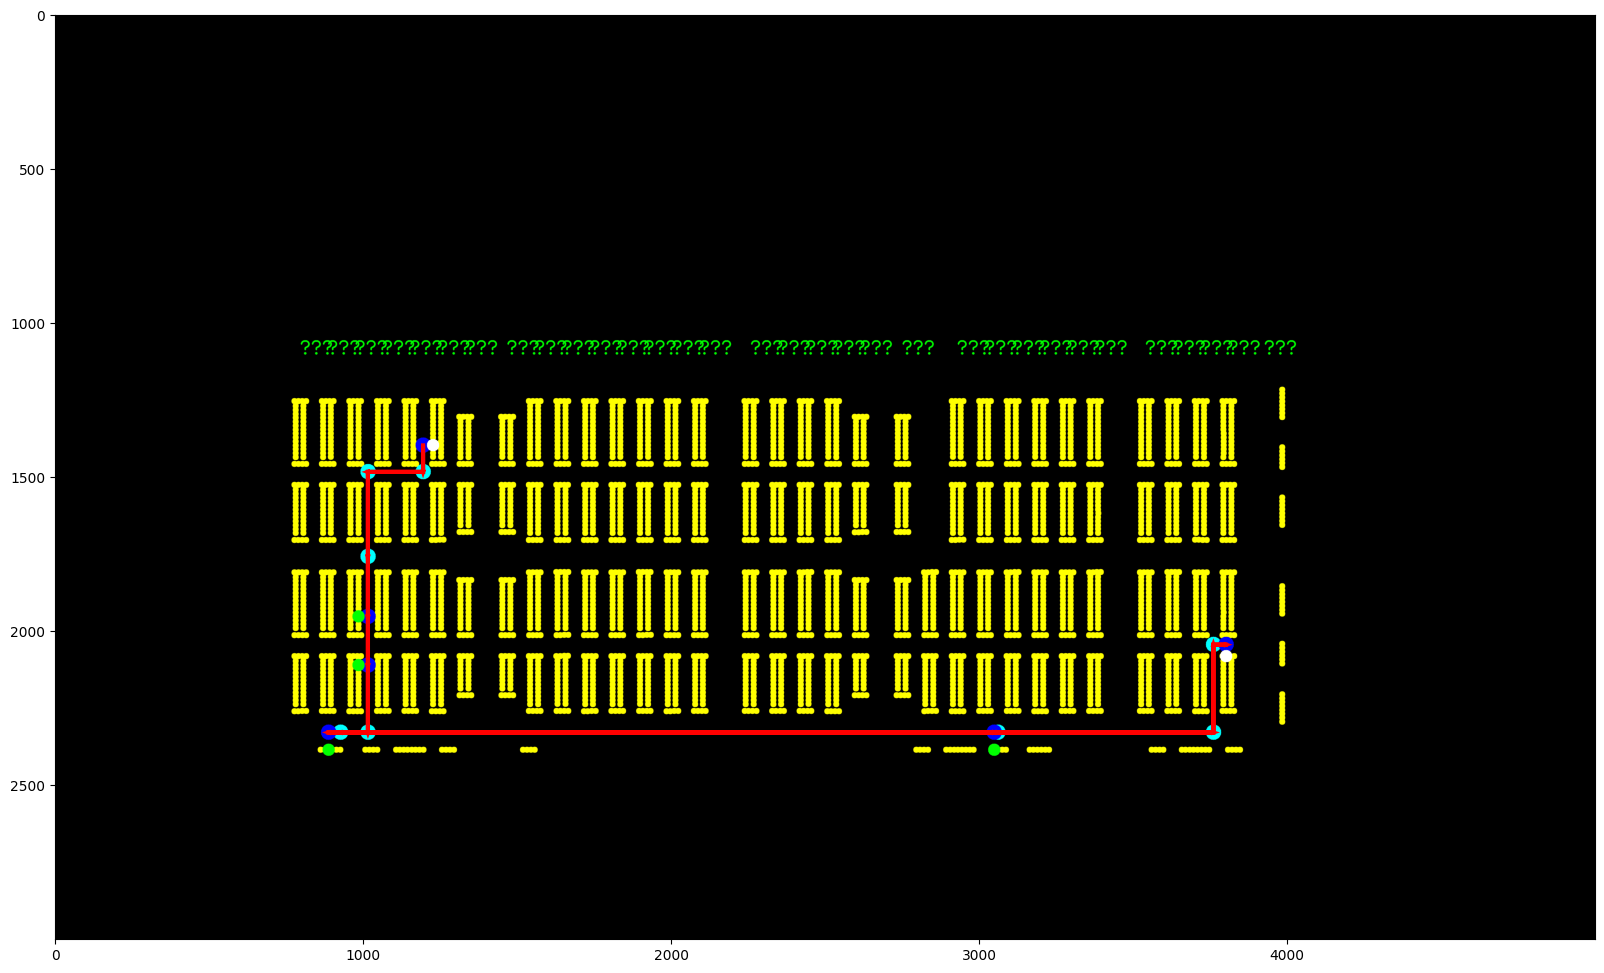

In [18]:
img = np.zeros((3000,5000,3), dtype=np.uint8)

print(circle_points)

for row in data:
    for coords in data[row].values():

        img = cv2.circle(img, tuple([int(x) for x in coords]), 10, (255, 255, 0), -1)

# Plot all row labels
row_center_list = [int(x)+30 for x in x_bins1]
for i in range(len(row_center_list)):

    img = cv2.putText(img, CHAR_LIST_ROW1[i], (row_center_list[i], 1100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)

# plot all nodes passed through
for i in range(len(current_route)-1):

    pts = all_dict[(current_route[i], current_route[i+1])][0]

    for pt in pts:
        # print(pt)
        img = cv2.circle(img, (pt[0], pt[1]), 25, (0, 255, 255), -1)

# Plot all concerned circles
for pt in points:
    img = cv2.circle(img, (pt[0], pt[1]), 25, (0, 0, 255), -1)

# Plot all concerned circle points

for pt in circle_points:

    img = cv2.circle(img, pt, 20, (0, 255, 0), -1)
    # img = cv2.putText(img, 'x', pt, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)

# Plot start and end circle points

for pt in [circle_points[0], circle_points[-1]]:

    img = cv2.circle(img, pt, 20, (255, 255, 255), -1)
    # img = cv2.putText(img, 'x', pt, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)

# img = img[1000:2500, 500:4500]

print(current_route)
plt.figure(figsize=(20, 12))
plt.imshow(img,cmap='gray', clip_on=False)

# Plot all arrows

for i in range(len(current_route)-1):

    x = (255/len(current_route)-1) * i

    pts = all_dict[(current_route[i], current_route[i+1])][0]

    for i in range(len(pts) - 1):
        print(pts[i][0], pts[i][1], pts[i+1][0], pts[i+1][1])
        plt.arrow(pts[i][0], pts[i][1], pts[i+1][0] - pts[i][0], pts[i+1][1] - pts[i][1], ec = "red", lw = 3)

plt.show()